In [3]:
import networkx as nx
# import torch
# from torch_geometric.data import Data
# import torch_geometric
# import numpy as np
# from torch_geometric.datasets import CoraFull, CitationFull
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
# from torch_geometric.data import Data

%config InlineBackend.figure_format = 'retina'
import numpy as np

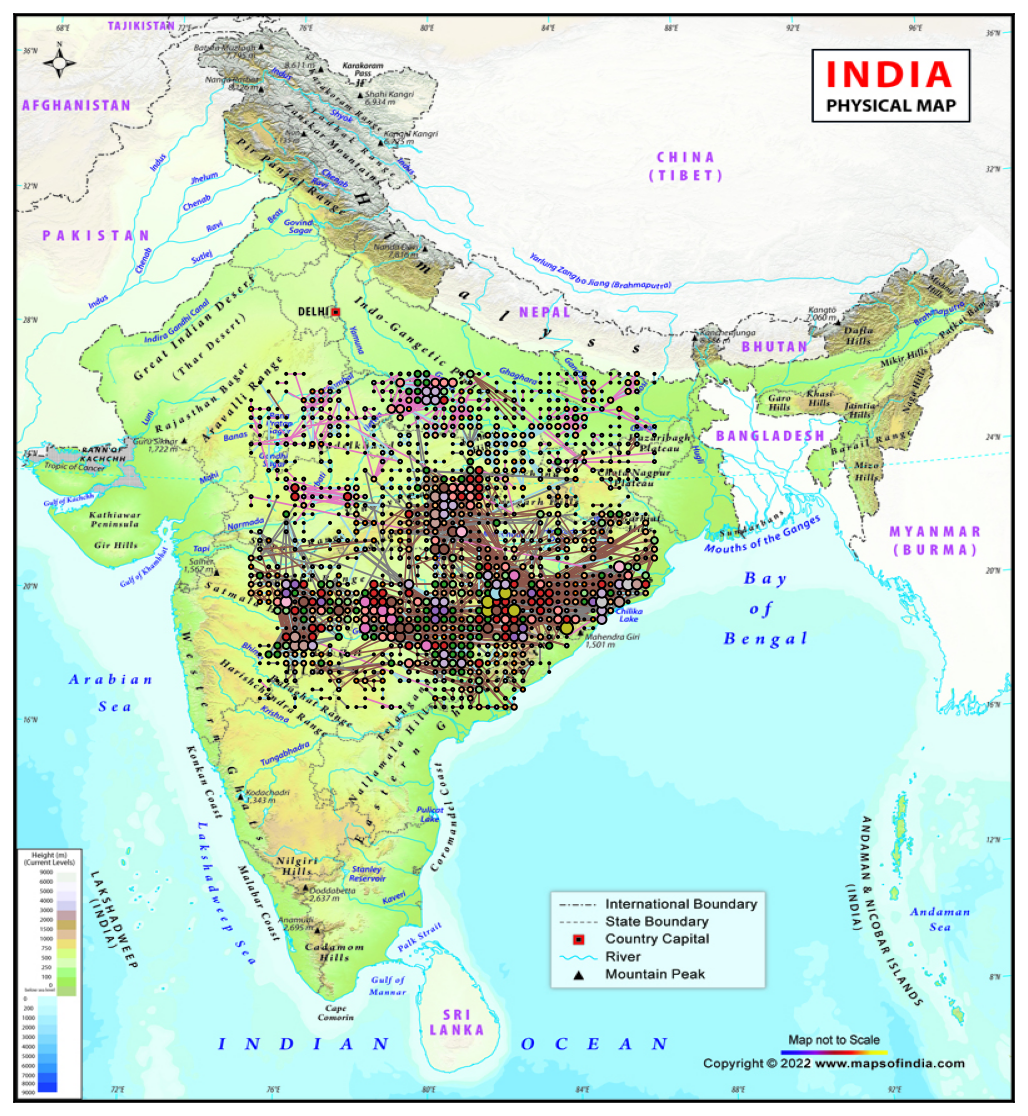

In [4]:
adj_matrix = np.load('/home/udit/Documents/Progyan/results_new_95/Year_2010.npy')
adj_matrix = adj_matrix + adj_matrix.transpose()
adj_matrix[adj_matrix < 0.8] = 0
np.fill_diagonal(adj_matrix, 0)

plt.figure(figsize=(10,10))
G = nx.from_numpy_matrix(adj_matrix)

# load latitude and longitude pairs from csv file  

lat_lon_df = pd.read_csv('/home/udit/Documents/Progyan/Lat_lon/lat_lon-2010.csv')

# create dictionary with node IDs as row indices and lat-lon 
# tuples as values
lat_lon_dict = {}
for i in range(len(lat_lon_df)):
    lat_lon_dict[i] = (lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'])

# add latitudes and longitudes as node attributes
nx.set_node_attributes(G, lat_lon_dict, 'pos')

# get node positions
pos = nx.get_node_attributes(G, 'pos')

central_nodes = []
for n in G.nodes:
    if G.nodes[n]['pos'][0] > 74.5 and G.nodes[n]['pos'][0] < 86.5 and G.nodes[n]['pos'][1] > 16.5 and G.nodes[n]['pos'][1] < 26.5:
        central_nodes.append(n)

G = G.subgraph(central_nodes)

# create new dictionary with node positions only within India's geographical bounds
# india_coords = [[67, 97], [5.5, 38]]
india_coords = [[74.5, 86.5], [16.5, 26.5]]
india_pos = {}
for node_id, coords in pos.items():
    # if coords[1] > 5.5 and coords[1] < 38 and coords[0] > 67 and coords[0] < 97:
    if coords[1] > 5.5 and coords[1] < 38 and coords[0] > 67 and coords[0] < 97:
        india_pos[node_id] = coords


# from pylab import rcParams
# rcParams['figure.figsize'] = 14, 10
# pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
d = dict(G.degree)
# cmap the node colour based on degree 
degree_dict = dict(G.degree()) # calculate the degree of each node and convert to a dictionary
degree_values = np.array(list(degree_dict.values())) # convert the degree dictionary to an array

cmap = plt.cm.get_cmap('tab20') # choose the color map you want to use
cmap_edge = plt.cm.get_cmap('tab20')



# normalize the degree values to a range between 0 and 1
normalized_degrees = (degree_values - degree_values.min()) / (degree_values.max() - degree_values.min())

# calculate the colors for each node based on its degree
node_colors = cmap(normalized_degrees)

# set edge width based on weight
edge_widths = [d['weight'] for (u, v, d) in G.edges(data=True)]
edge_colors = [d['weight']**3 for (u, v, d) in G.edges(data=True)]
# edge_colors = [1 for (u, v, d) in G.edges(data=True)]
# edge_colors = 'black'

edge_colors = cmap_edge(edge_colors)
# list of cmaps
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
# they are, in order: virids,


nx.draw_networkx(G, pos = india_pos,
        nodelist=d, 
        width=edge_widths,
        edge_color=edge_colors,
        edgecolors = 'black',
        node_size=[(d[k])**1.1 for k in d],
        with_labels = False,
        # edge_color='grey',
        node_color=node_colors,)
# nx.draw_networkx(G, pos=india_pos, node_size=4, width=0.2, with_labels=False)
plt.savefig('graph1.png')

# superimpose an image with low alpha
img = plt.imread('/home/udit/Documents/Progyan/GNN/physical-map-india.jpg')
plt.imshow(img, extent=[68, 96.5, 5.5, 36.5], alpha=1)
plt.savefig('graph2.png')

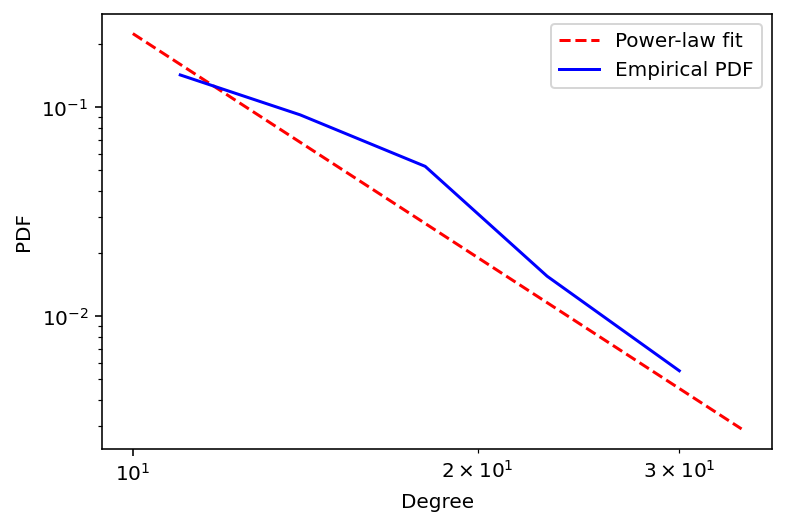

alpha=  3.5577652927703722   sigma=  0.189594177544552


In [5]:
import powerlaw
import numpy as np
import matplotlib.pyplot as plt

degrees = []
for i in G.degree:
    temp = i[1]
    degrees.append(temp)

fit = powerlaw.Fit(np.array(degrees)+1, xmin=10, discrete=True)
fit.power_law.plot_pdf(color='r', linestyle='--', label='Power-law fit')
fit.plot_pdf(color='b', label='Empirical PDF')

plt.xlabel('Degree')
plt.ylabel('PDF')
plt.legend(loc='upper right')
plt.show()

print('alpha= ', fit.power_law.alpha, '  sigma= ', fit.power_law.sigma)


In [6]:
nx.__version__

'2.4'

In [7]:
max_degree

NameError: name 'max_degree' is not defined

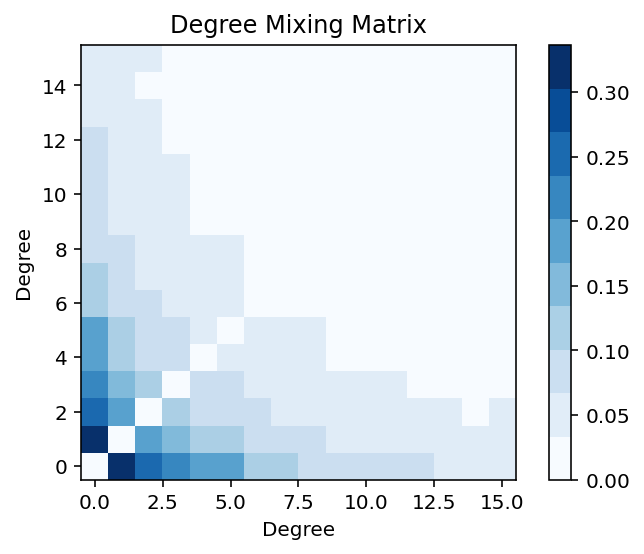

In [ ]:
max_degree = 15

# Compute the degree mixing matrix
degree_pairs = list(G.degree())
degree_matrix = np.zeros((max_degree + 1, max_degree + 1))
for i in range(len(degree_pairs)):
    if degree_pairs[i][1] > max_degree:
        continue
    for j in range(i, len(degree_pairs)):
        if degree_pairs[j][1] > max_degree:
            continue
        if degree_pairs[i][1] > degree_pairs[j][1]:
            degree_matrix[degree_pairs[i][1], degree_pairs[j][1]] += 1
            degree_matrix[degree_pairs[j][1], degree_pairs[i][1]] += 1
        elif degree_pairs[i][1] < degree_pairs[j][1]:
            degree_matrix[degree_pairs[j][1], degree_pairs[i][1]] += 1
            degree_matrix[degree_pairs[i][1], degree_pairs[j][1]] += 1

# Normalize the rows and columns of the degree mixing matrix
row_sums = degree_matrix.sum(axis=1)
col_sums = degree_matrix.sum(axis=0)
for i in range(degree_matrix.shape[0]):
    for j in range(degree_matrix.shape[1]):
        degree_matrix[i, j] /= np.sqrt(row_sums[i] * col_sums[j])

# Plot the degree mixing matrix as a heatmap
plt.imshow(degree_matrix[:max_degree+1,:max_degree+1], cmap=plt.cm.get_cmap('Blues', 10), interpolation='nearest')
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('Degree')
plt.ylabel('Degree')
plt.title('Degree Mixing Matrix')
plt.show()


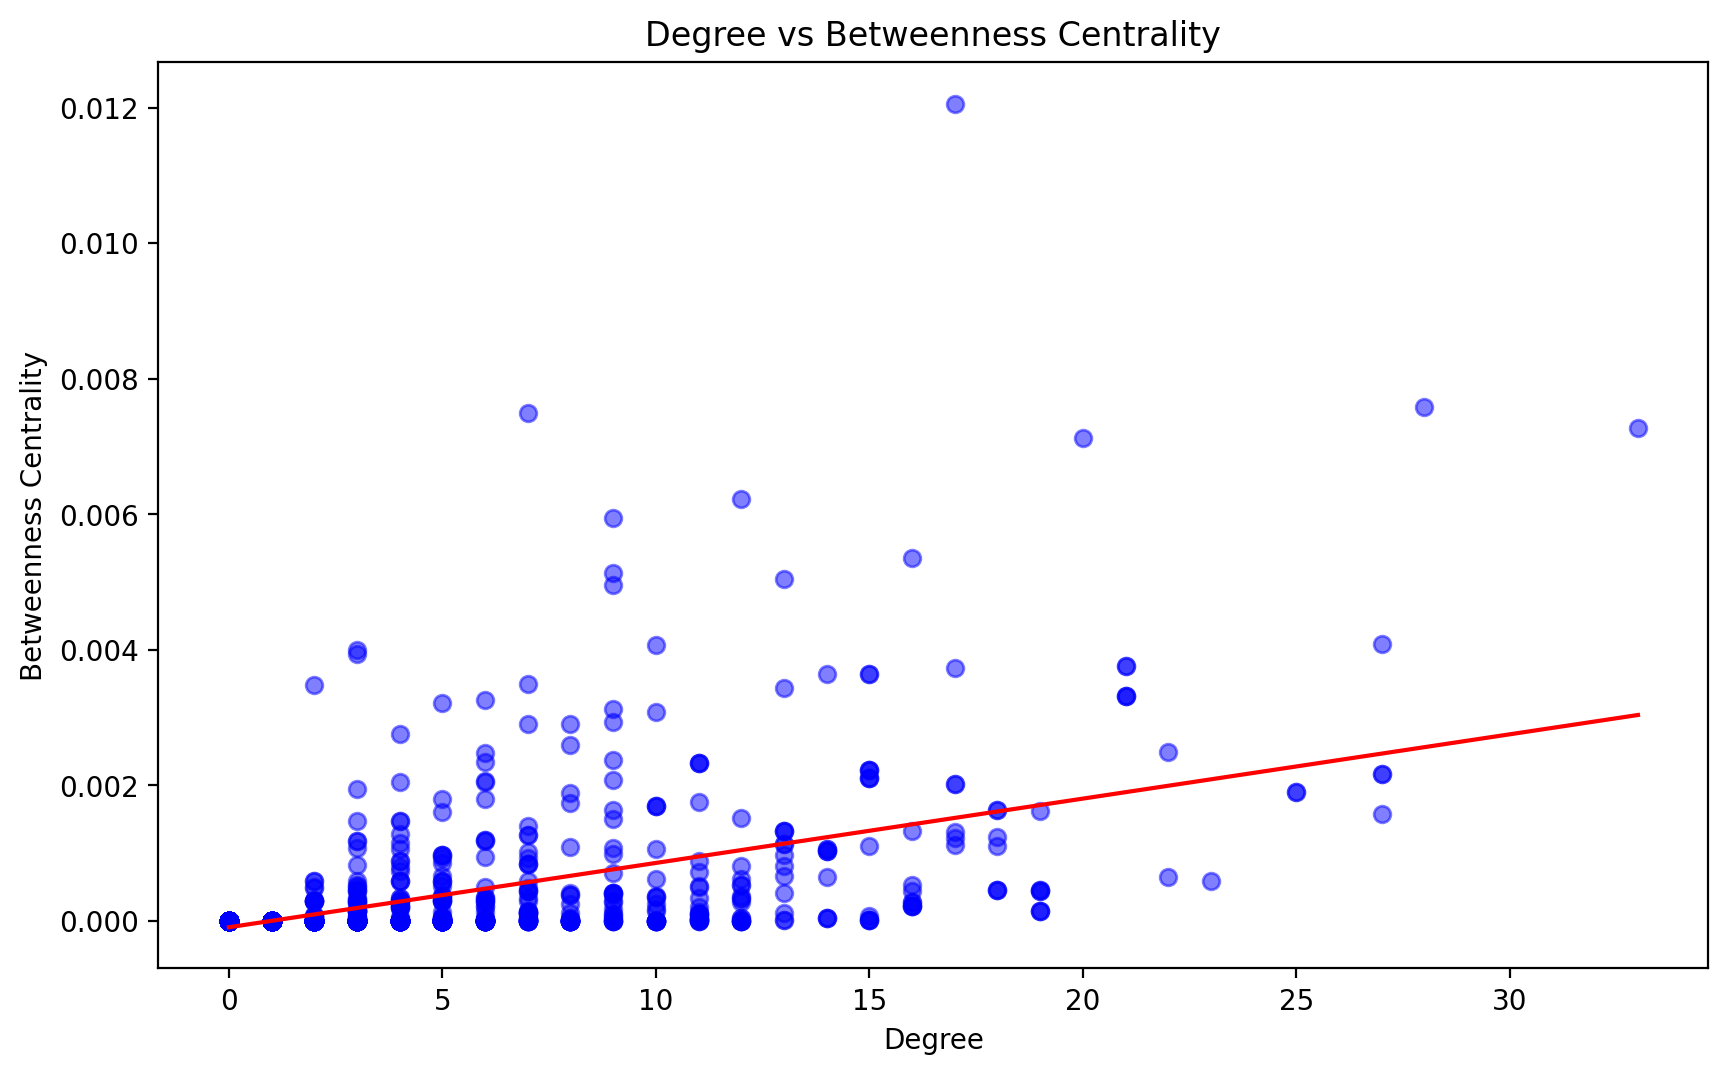

In [8]:
bc = nx.betweenness_centrality(G)
degree = dict(G.degree)

# Get x and y values
x = np.array(list(degree.values()))
y = np.array(list(bc.values()))

# Compute a linear regression of y vs x
m, b = np.polyfit(x, y, 1)
line_x = np.array([min(x), max(x)])
line_y = m * line_x + b

# Plot the data points and linear regression
plt.scatter(x, y, color='blue', alpha=0.5)
plt.plot(line_x, line_y, color='red')

# Set axis labels and title
plt.xlabel('Degree')
plt.ylabel('Betweenness Centrality')
plt.title('Degree vs Betweenness Centrality')

# Set the figure size and resolution
fig = plt.gcf()
fig.set_size_inches(10, 6)
fig.set_dpi(100)

# Save the figure
plt.show()

In [10]:
G = G.copy()
max_degree = 15
degree_seq = [d for n, d in G.degree()]
to_remove = [n for n in G.nodes() if G.degree(n) > max_degree]
G.remove_nodes_from(to_remove)

# Compute the degree correlation coefficient
r = nx.degree_assortativity_coefficient(G)
print('Degree correlation coefficient:', r)

Degree correlation coefficient: 0.5985810835456866


In [1]:
# get adj matrix
adj_matrix = nx.to_numpy_matrix(G)

NameError: name 'nx' is not defined

In [4]:
len(india_pos)

4523

In [5]:
from torch_geometric_temporal import ChickenpoxDatasetLoader
from torch_geometric_temporal import temporal_signal_split
loader = ChickenpoxDatasetLoader()
dataset = loader.get_dataset()

In [36]:
# convert adjacency matrix to edge list
edge_list = set()
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        if adj_matrix[i, j] > 0:
            append_edge = frozenset({i, j})
            edge_list.add(append_edge)
edge_list = [tuple(x) for x in list(edge_list)]

In [37]:
lat_lon_df = lat_lon_df.iloc[central_nodes]

In [130]:
from torch_geometric.utils import to_undirected

In [38]:
node_features = []
for i in lat_lon_df.index:
    node_features.append([lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat']])
node_features = torch.tensor(node_features, dtype=torch.float)


In [39]:
edge_list = torch.tensor(edge_list)
edge_list = edge_list.t()

In [136]:
from torch_geometric.transforms import ToUndirected

transform = ToUndirected()
graph_data = transform(Data(x = node_features, edge_index = edge_list))

In [143]:
# convert Data to networkx
from torch_geometric.utils import to_networkx
G = to_networkx(graph_data, to_undirected = True)

In [148]:
G = nx.from_numpy_matrix(adj_matrix)
G = G.subgraph(central_nodes)
G_ = to_networkx(graph_data, to_undirected = True)

In [149]:
central_pos = {}
for _, i in enumerate(central_nodes):
    central_pos[_] = pos[i]

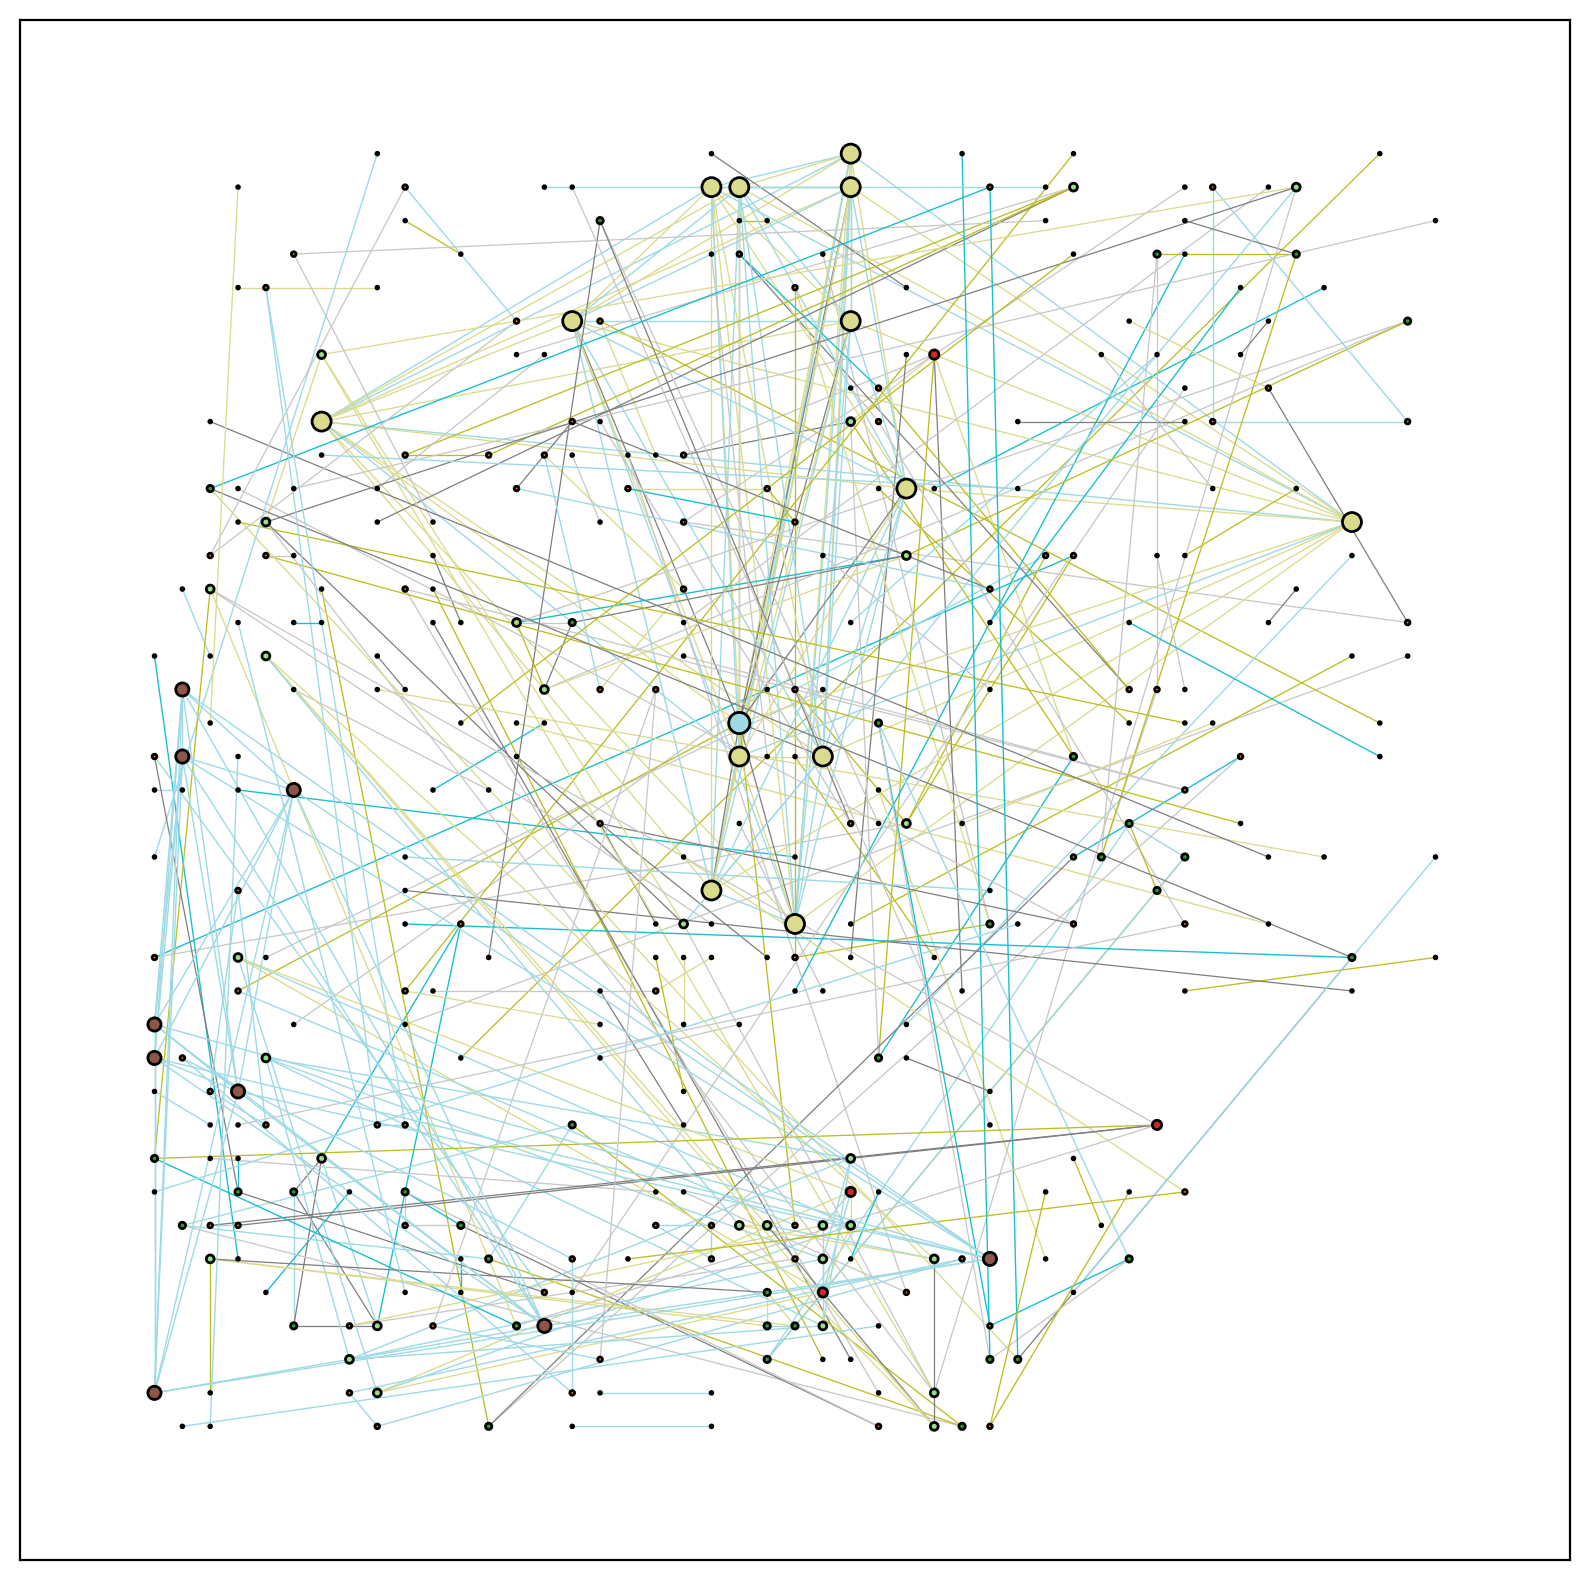

In [152]:
# plot G and G_
plt.figure(figsize=(10,10))
nx.draw_networkx(G_, pos = central_pos,
        width=[edge_width*0.5 for edge_width in edge_widths],
        edge_color=edge_colors,
        edgecolors = 'black',
        node_size=[(d[k])**1.5 for k in d],
        with_labels = False,
        node_color=node_colors,)


In [153]:
graph_data

Data(x=[1700, 2], edge_index=[2, 844])

In [155]:
graph_data.num_classes

AttributeError: 'GlobalStorage' object has no attribute 'num_classes'